In [1]:
import os
import sys

# Get the current working directory and add the parent directory to the Python path
current_working_directory = os.getcwd()
print(os.path.join(current_working_directory, ".."))
sys.path.append(os.path.join(current_working_directory, ".."))

/Users/L024258/lilly_work/github-copilot/exploration/langgraph/..


In [2]:
import pprint

### Defining the Graph state

In [3]:
from typing import TypedDict, Annotated, List, Union
from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.messages import BaseMessage, HumanMessage
import operator
from IPython.display import Image, display

In [4]:
from langgraph.types import Command, interrupt

In [5]:
class AgentState(TypedDict):
    input: str
    agent_outcome: Union[AgentAction, AgentFinish, None]
    intermediate_step: Annotated[list, operator.add]

In [6]:
from langchain_community.tools.arxiv.tool import ArxivQueryRun
from langchain_community.tools.pubmed.tool import PubmedQueryRun
from langchain_community.tools.tavily_search import TavilySearchResults

pubmed_search = PubmedQueryRun()
arxiv_search = ArxivQueryRun()
tavily_tool = TavilySearchResults(max_results=5)

tools = [arxiv_search, pubmed_search, tavily_tool]
# tools = [arxiv_search, pubmed_search]
# tools = [arxiv_search]

In [7]:
from langchain_core.tools import tool

@tool
def request_user_feedback(query: str) -> str:
    """Request assistance or feedback from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]

tools.append(request_user_feedback)


In [8]:
from models.llm import LLM

model = LLM('gpt-4o-mini')
llm = model.load_model()

In [9]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

def research_agent(data):
    print("----research node----")
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI research assistant chatbot,"
                " Provided a user query generate 2 more similar queries and search for relevant results."
                " Use the appropriate search tools to progress towards finding the relevant results."
                " Once you have the relevant search results, take user feedback."
                " If user says No/no (indicating No more searching), summarise the search results to answer the user query"
                "\nYou have access to the following search tools: {tool_names}."
            ),
            (
                "human",
                "\nUser Query: {input}"
            ),
            
            MessagesPlaceholder(variable_name="intermediate_step"),
        ]
    )
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    agent = prompt | llm.bind_tools(tools)
    result = agent.invoke(data)
    return {'agent_outcome': [result]}

In [21]:
from langgraph.graph import END, StateGraph
workflow = StateGraph(AgentState)

workflow.add_node("research", research_agent)
workflow.set_entry_point("research")

In [22]:
import json
from langchain_core.messages import ToolMessage

class BasicToolNode:
    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        print("----tool calling----")
        message = inputs["agent_outcome"][-1]

        outputs = []
        for tool_call in message.tool_calls:
            print(f"---- Calling {tool_call['name']} with args: {tool_call['args']} ----")
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )

        return {
                "agent_outcome": outputs,
                "intermediate_step": [str(outputs)]
            }

tool_node = BasicToolNode(tools=tools)
workflow.add_node("tools", tool_node)

In [23]:
def route_tools(
    state: AgentState,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    print("----router----")
    if isinstance(state, list):
        ai_message = state[-1]
    elif agent_outcome := state.get("agent_outcome", []):
        ai_message = agent_outcome[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")

    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END

In [24]:
workflow.add_conditional_edges(
    "research",
    route_tools,
    {"tools": "tools", END: END}
)

In [25]:
workflow.add_edge("tools", "research")

In [26]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

#### Adding Human in the Loop (HIL)

- `interrupt_before (Optional[Union[All, Sequence[str]]], default: None )` – Nodes to interrupt before, defaults to all nodes in the graph.
- `interrupt_after (Optional[Union[All, Sequence[str]]], default: None )` – Nodes to interrupt after, defaults to all nodes in the graph.

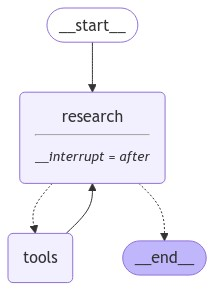

In [27]:
app = workflow.compile(
    checkpointer=memory,
    interrupt_after=["research"],)
try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

##### Starting Conversation

In [28]:
inputs = {
    "input": "What are the recent papers on Small Language Models?",
}

config = {
    "configurable": {
        "thread_id": "123",
    }
}

state = AgentState(**inputs)
events = app.stream(input=state, config=config, stream_mode="values")
for event in events:
    try:
        for msg in event["agent_outcome"]:
            msg.pretty_print()
    except Exception:
        HumanMessage(event["input"]).pretty_print()

================================ Human Message =================================

What are the recent papers on Small Language Models?
----research node----
----router----
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_ONsYgXJ7vt0DmB2lcWWd3jKY)
 Call ID: call_ONsYgXJ7vt0DmB2lcWWd3jKY
  Args:
    query: Small Language Models
  tavily_search_results_json (call_GLJyBrkQz0LDQNp3GTcIdAwC)
 Call ID: call_GLJyBrkQz0LDQNp3GTcIdAwC
  Args:
    query: recent papers on Small Language Models


The execution got stopped after the tools call.

In [29]:
snapshot = app.get_state(config)
snapshot

StateSnapshot(values={'input': 'What are the recent papers on Small Language Models?', 'agent_outcome': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ONsYgXJ7vt0DmB2lcWWd3jKY', 'function': {'arguments': '{"query": "Small Language Models"}', 'name': 'arxiv'}, 'type': 'function'}, {'id': 'call_GLJyBrkQz0LDQNp3GTcIdAwC', 'function': {'arguments': '{"query": "recent papers on Small Language Models"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 55, 'prompt_tokens': 345, 'total_tokens': 400, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_5154047bf2', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'ja

In [30]:
snapshot.next

('tools',)

In [31]:
snapshot.values["agent_outcome"]

[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ONsYgXJ7vt0DmB2lcWWd3jKY', 'function': {'arguments': '{"query": "Small Language Models"}', 'name': 'arxiv'}, 'type': 'function'}, {'id': 'call_GLJyBrkQz0LDQNp3GTcIdAwC', 'function': {'arguments': '{"query": "recent papers on Small Language Models"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 55, 'prompt_tokens': 345, 'total_tokens': 400, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_5154047bf2', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 

In [32]:
events = app.stream(None, config, stream_mode="values")

for event in events:
    try:
        for msg in event["agent_outcome"]:
            msg.pretty_print()
    except Exception as e:
        HumanMessage(event["input"]).pretty_print()
    print("-----"*20)

================================== Ai Message ==================================
Tool Calls:
  arxiv (call_ONsYgXJ7vt0DmB2lcWWd3jKY)
 Call ID: call_ONsYgXJ7vt0DmB2lcWWd3jKY
  Args:
    query: Small Language Models
  tavily_search_results_json (call_GLJyBrkQz0LDQNp3GTcIdAwC)
 Call ID: call_GLJyBrkQz0LDQNp3GTcIdAwC
  Args:
    query: recent papers on Small Language Models
----------------------------------------------------------------------------------------------------
----tool calling----
---- Calling arxiv with args: {'query': 'Small Language Models'} ----
---- Calling tavily_search_results_json with args: {'query': 'recent papers on Small Language Models'} ----
================================= Tool Message =================================
Name: arxiv

"Published: 2022-01-26\nTitle: An Assessment of the Impact of OCR Noise on Language Models\nAuthors: Konstantin Todorov, Giovanni Colavizza\nSummary: Neural language models are the backbone of modern-day natural language\nprocessing 

In [33]:
snapshot = app.get_state(config)
snapshot

StateSnapshot(values={'input': 'What are the recent papers on Small Language Models?', 'agent_outcome': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_M05w8phoFb93IkFzckBnIZIG', 'function': {'arguments': '{"query": "Small Language Models"}', 'name': 'arxiv'}, 'type': 'function'}, {'id': 'call_QpqVBUBPDj9vYxwsSGTmeHMZ', 'function': {'arguments': '{"query": "recent papers on Small Language Models"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 55, 'prompt_tokens': 1976, 'total_tokens': 2031, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_5154047bf2', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, '

In [34]:
snapshot.next

('tools',)

In [35]:
snapshot.values["agent_outcome"]

[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_M05w8phoFb93IkFzckBnIZIG', 'function': {'arguments': '{"query": "Small Language Models"}', 'name': 'arxiv'}, 'type': 'function'}, {'id': 'call_QpqVBUBPDj9vYxwsSGTmeHMZ', 'function': {'arguments': '{"query": "recent papers on Small Language Models"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 55, 'prompt_tokens': 1976, 'total_tokens': 2031, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_5154047bf2', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}

In [36]:
human_command = Command(resume={"data": None})

events = app.stream(human_command, config, stream_mode="values")
for event in events:
    try:
        for msg in event["agent_outcome"]:
            msg.pretty_print()
    except Exception as e:
        HumanMessage(event["input"]).pretty_print()
    print("-----"*20)

----tool calling----
---- Calling arxiv with args: {'query': 'Small Language Models'} ----
---- Calling tavily_search_results_json with args: {'query': 'recent papers on Small Language Models'} ----
================================= Tool Message =================================
Name: arxiv

"Published: 2022-01-26\nTitle: An Assessment of the Impact of OCR Noise on Language Models\nAuthors: Konstantin Todorov, Giovanni Colavizza\nSummary: Neural language models are the backbone of modern-day natural language\nprocessing applications. Their use on textual heritage collections which have\nundergone Optical Character Recognition (OCR) is therefore also increasing.\nNevertheless, our understanding of the impact OCR noise could have on language\nmodels is still limited. We perform an assessment of the impact OCR noise has\non a variety of language models, using data in Dutch, English, French and\nGerman. We find that OCR noise poses a significant obstacle to language\nmodelling, with langua

In [ ]:
events = app.stream(input=None, config=config, stream_mode="values")
for event in events:
    try:
        for msg in event["agent_outcome"]:
            msg.pretty_print()
    except Exception as e:
        HumanMessage(event["input"]).pretty_print()
    print("-----"*20)

In [ ]:
snapshot = app.get_state(config)
snapshot

In [ ]:
snapshot.next